# Identify Pytorch to TensorRT Conversion Path
In my [previos tests](https://github.com/bhlarson/mllib#readme), converting Tensorflow models to TensorRT resulted in a ~ 10x reduction in runtime without reducing inference accuracy.  Following the same process for PyTorch models resulted in an incorrect TensorRT inference.  

[This file](https://github.com/bhlarson/mllib/blob/master/TestONNXTRT.ipynb) isolates the ONNX to TensorRT conversion to identify usage or conversion errors that may explain the TensorRT inference failure.  In troubleshooting this process, I have updated to [TensorRT 8.2](https://docs.nvidia.com/deeplearning/tensorrt/developer-guide/index.html) and incorperated the conversion calls described in TensorRT 8.2 documentation.  

Process:
1. Clone [MLLIB](https://github.com/bhlarson/mllib) project:
```console
git clone https://github.com/bhlarson/mllib.git
```
2. Fom the mllib directory, create an empty creds.json file and, build docker containers:
```console
cd mllib
echo '{}' > creds.json
./build
```
3. Start the NVIDIA pytorch docker container in console mode:
```console
./dtr
```
4. From the docker command line, start the jupyter engine to run this notebook:
```console
./lab
```
5. Open a chrome browser to [http://localhost:9999](http://localhost:9999)
1. Open a TestONNXTRT.ipynb in Jupyter
1. From the Jupyter Lab toolbar, Select Run->Run All Cells to run ONNX inference, ONNX to TensorRT conversion, and TensorRT conversion.
1. Note that ONNX inference segments, people, animals, and vehicles
1. Note the ONNX to TensorRT conversion is successful witout errors
1. Note the TensorRT inference is corrupted with a 4x4 pattern in the inference image which is overlayed on top of the original image.   

The inference results in this example are displayed as a per-chanel mask on top of the original image.  

Of particular note for this study is
1. [onnx-trt.py](./target/onnx-trt.py) implements the ONNX to TRT conversion described in the [NVIDIA TENSORRT DOCUMENTATION](https://docs.nvidia.com/deeplearning/tensorrt/developer-guide/index.html#network_python)
1. [target.trtinference](./target/trtinference.py) implements TRT inference described in the [NVIDIA TENSORRT DOCUMENTATION](https://docs.nvidia.com/deeplearning/tensorrt/developer-guide/index.html#network_python)

In [1]:
import sys, os
from glob import glob
import tqdm
import onnxruntime as ort
import numpy as np
import cv2
import IPython
# locate imports from either mllib directory or target directory
sys.path.append(os.path.abspath(''))
sys.path.append(os.path.abspath('..'))
from pymlutil.jsonutil import ReadDictJson
from datasets.cocostore import resize_crop_or_pad
from pymlutil.metrics import MergeIman, DatasetResults
from target.trtinference import TrtInference

In [2]:
def imshow(img):
    import cv2
    import IPython
    _,ret = cv2.imencode('.jpg', img) 
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)

In [3]:
height = 480
width = 512
batch_size = 1
images = glob('test/*.jpg')
class_dictionary_name= 'test/coco.json'
onnxmodelname='test/segment_nas_512x442_20211119_00.onnx'
trtmodelname='test/segment_nas_512x442_20211119_00.trt'
trtprecision='fp16'

In [4]:
class_dictionary = ReadDictJson(class_dictionary_name)

In [5]:
onnxsess = ort.InferenceSession(onnxmodelname)
input_name = onnxsess.get_inputs()[0].name
input_name

/opt/conda/lib/python3.8/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:350: UserWarning: Deprecation warning. This ORT build has ['CUDAExecutionProvider', 'CPUExecutionProvider'] enabled. The next release (ORT 1.10) will require explicitly setting the providers parameter (as opposed to the current behavior of providers getting set/registered by default based on the build flags) when instantiating InferenceSession.For example, onnxruntime.InferenceSession(..., providers=["CUDAExecutionProvider"], ...)
  warnings.warn("Deprecation warning. This ORT build has {} enabled. ".format(available_providers) +


'image'

In [6]:
dsResults = DatasetResults(class_dictionary)

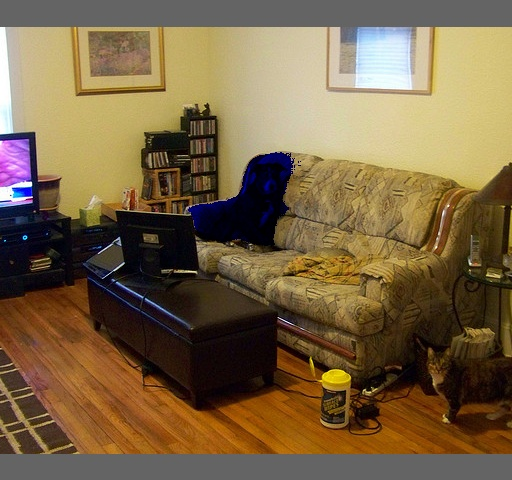

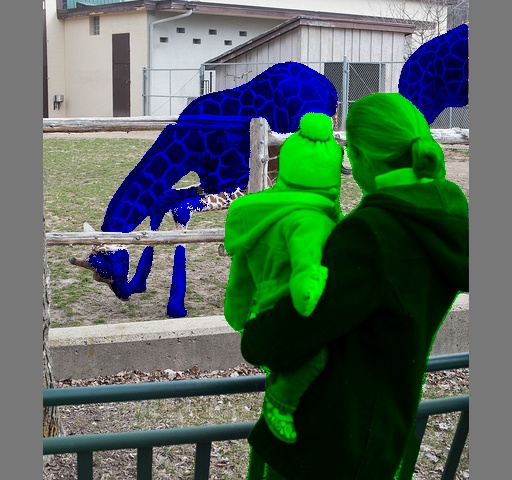

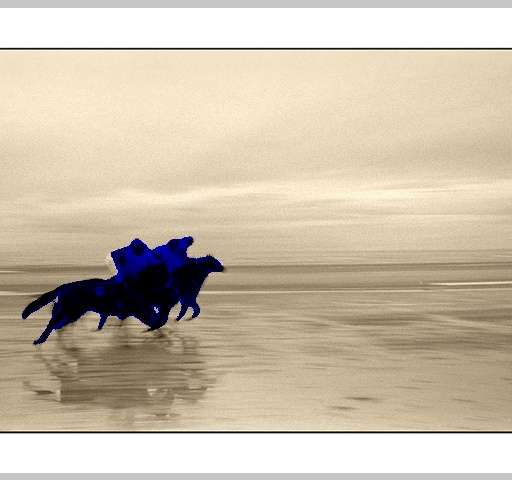

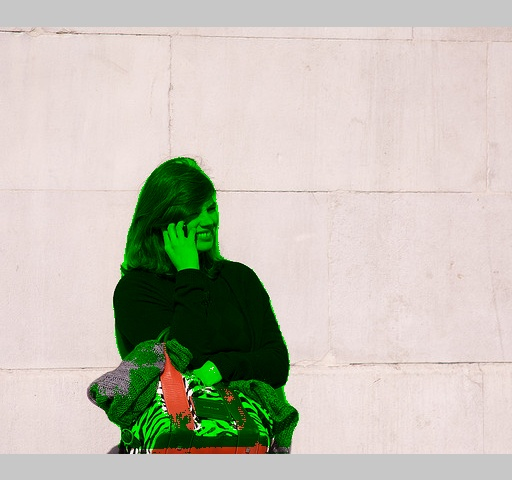

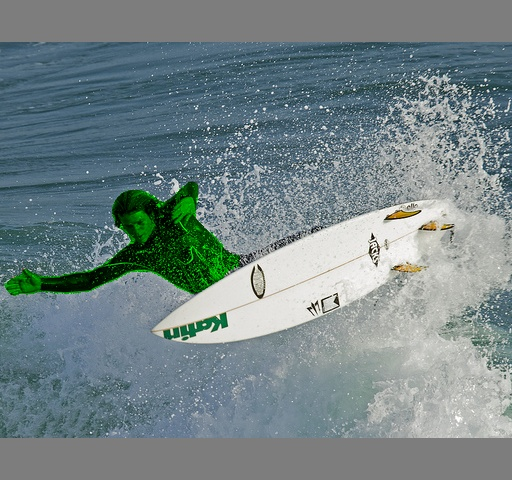

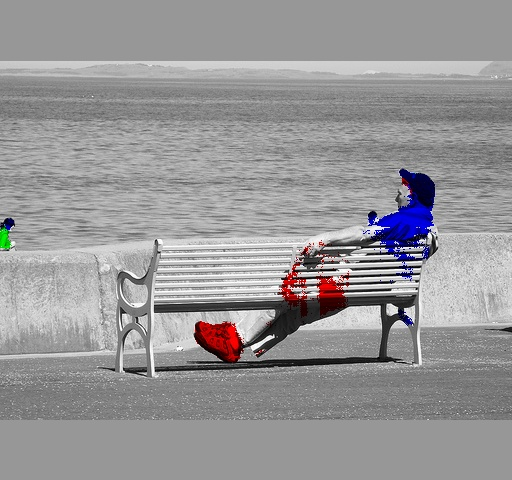

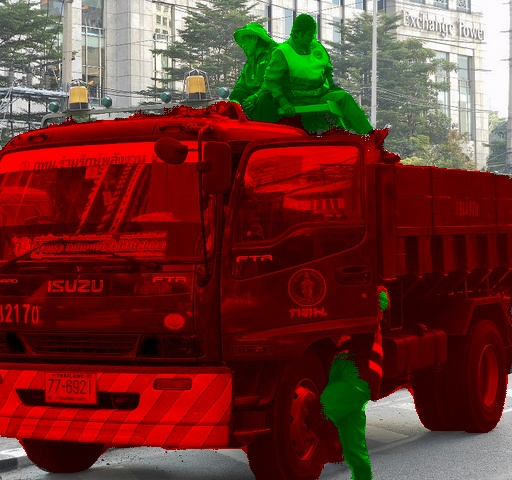

In [7]:
for imagename in images:
    image = cv2.imread(imagename)
    image, imgMean, imgStd = resize_crop_or_pad(image, height,width)
    imageBCHW = np.expand_dims(image.transpose(2, 0, 1),0).astype('float32')
    predonnx = onnxsess.run(None, {input_name: imageBCHW})
    segmentation = np.argmax(predonnx[0], axis=1).astype('uint8')[0]

    iman = MergeIman(image, segmentation, dsResults.lut,imgMean, imgStd)
    imshow(iman)

In [8]:
!python3 target/onnx-trt-file.py  -onnxname {onnxmodelname} -trtname {trtmodelname} -precision {trtprecision}

onnx-trt-file config={'debug': False, 'debug_port': 3000, 'debug_address': '0.0.0.0', 'trtname': 'test/segment_nas_512x442_20211119_00.trt', 'onnxname': 'test/segment_nas_512x442_20211119_00.onnx', 'workspace_memory': 8000, 'batch_size': 1, 'precision': 'fp16', 'platform': 'Linux-5.10.0-1044-oem-x86_64-with-glibc2.10', 'python': '3.8.12', 'onnx version': '1.10.1', 'tensorrt version': '8.0.3.4', 'numpy version': '1.21.4'}
[TensorRT] INFO: [MemUsageChange] Init CUDA: CPU +330, GPU +0, now: CPU 385, GPU 3138 (MiB)
[TensorRT] INFO: ----------------------------------------------------------------
[TensorRT] INFO: Input filename:   /tmp/tmpb75tccea.onnx
[TensorRT] INFO: ONNX IR version:  0.0.6
[TensorRT] INFO: Opset version:    11
[TensorRT] INFO: Producer name:    pytorch
[TensorRT] INFO: Producer version: 1.10
[TensorRT] INFO: Domain:           
[TensorRT] INFO: Model version:    0
[TensorRT] INFO: Doc string:       
[TensorRT] INFO: --------------------------------------------------------

In [9]:
trtserializedmodel = None
with open(trtmodelname, "rb") as f:
    trtserializedmodel = f.read()

In [10]:
inf = TrtInference(trtserializedmodel, batch_size, height, width, class_dictionary)

input shape: (1, 3, 480, 512)


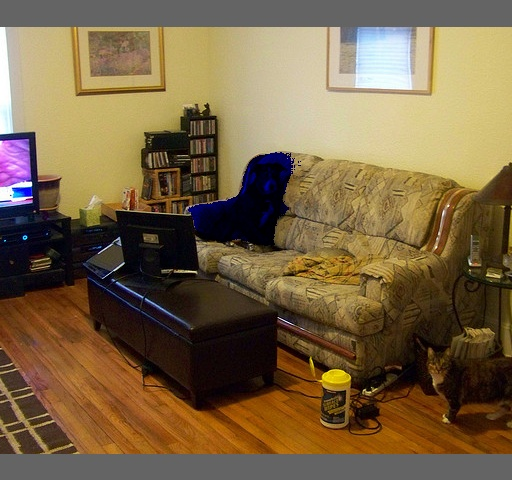

input shape: (1, 3, 480, 512)


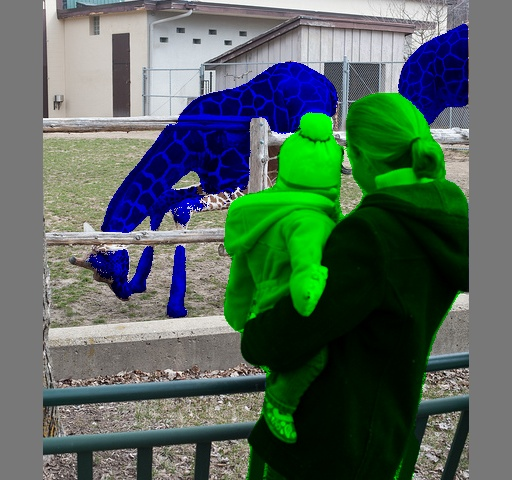

input shape: (1, 3, 480, 512)


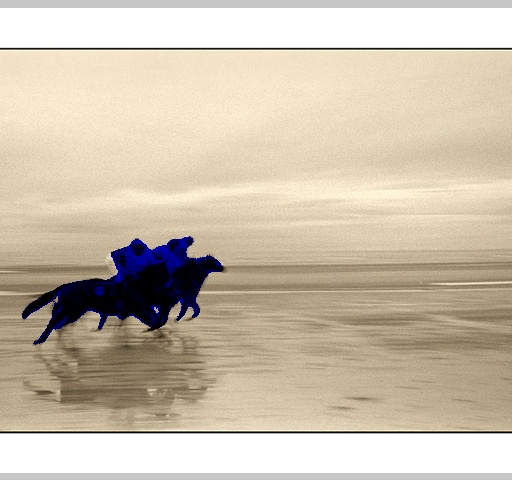

input shape: (1, 3, 480, 512)


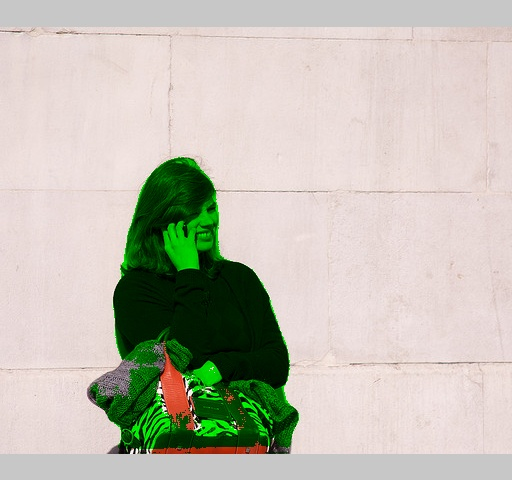

input shape: (1, 3, 480, 512)


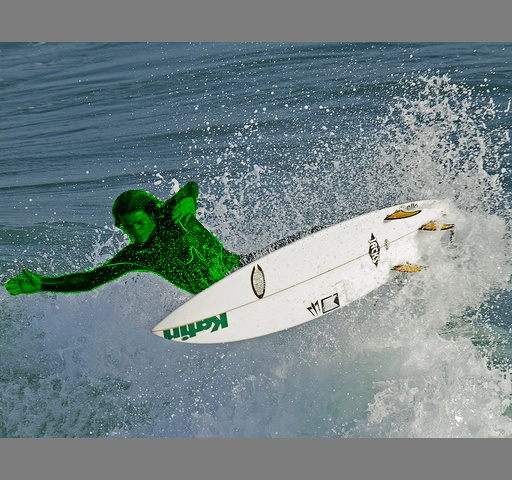

input shape: (1, 3, 480, 512)


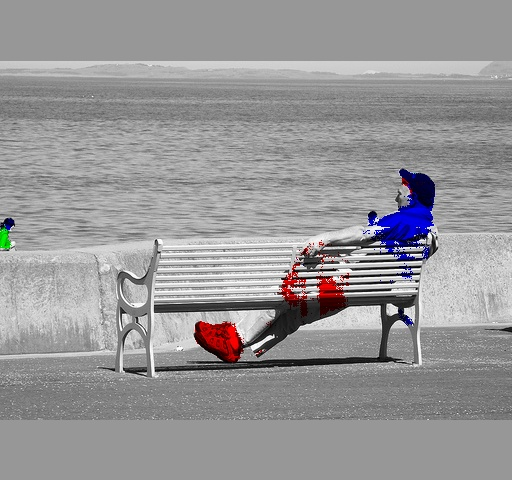

input shape: (1, 3, 480, 512)


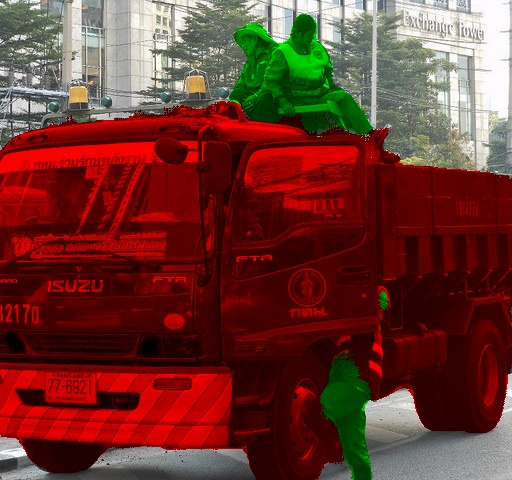

In [11]:
for imagename in images:
    image = cv2.imread(imagename)
    image, imgMean, imgStd = resize_crop_or_pad(image, height,width)
    imageBCHW = np.expand_dims(image.transpose(2, 0, 1),0).astype('float32')
    print('input shape: {}'.format(imageBCHW.shape))
    segmentation = inf.predict(np.ascontiguousarray(imageBCHW))[0]
    iman = MergeIman(image, segmentation, dsResults.lut,imgMean, imgStd)
    imshow(iman)